# The `.ml` extension

This notebook explores some of the popular examples from the machine learning extension of `turbopanda`.

In [1]:
import sys
import numpy as np
import pandas as pd
sys.path.insert(0,"../")
# our main import
import turbopanda as turb

import matplotlib.pyplot as plt
%matplotlib inline

print("turbopanda: %s" % turb.__version__)

turbopanda: 0.2.6


## Using *basic fit*: Fitting models using Linear Regression (OLS)

Given four key ingredients:

- `df`: A `MetaPanda` object
- `x`: A selector or list of columns in `df`
- `y`: A string selecting the target
- `model`: A string of which sklearn object to use, by default using `LinearRegression`

We fit this model to the data and return:

1. `cv`: the cross-validated repeat results of test scores, train scores, fit times etc, in addition to coefficients
for each parameter if available.
2. `yp`: the cross-validated predicted values for each element.

### Random cases: using sklearn simulated data

Case \#1: Fitting an ordinary linear model where all the parameters have some sort of **useful** input:

In [2]:
from sklearn.datasets import make_regression, make_classification

In [3]:
_X1, _y1 = make_regression(150, n_features=5, n_informative=4, bias=3., noise=1.5)
df1 = pd.DataFrame(np.hstack((_X1, np.atleast_2d(_y1).T)), columns=turb.str.patproduct("x%d", range(5)) + ["y"])

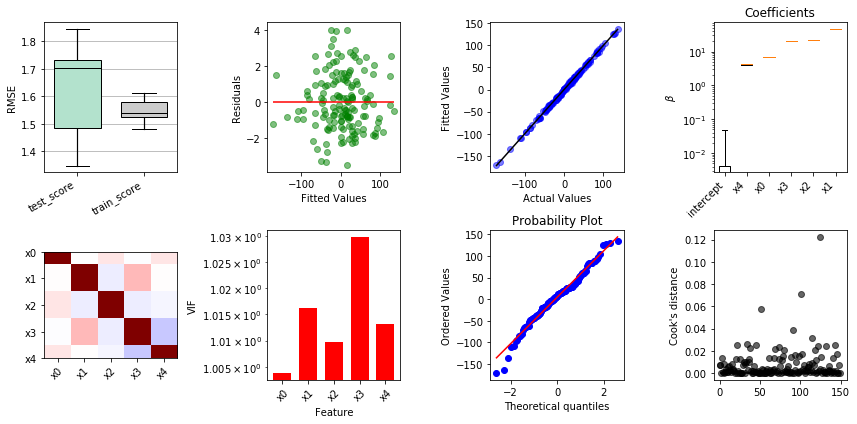

-1.6228716663991285

In [4]:
cv, yp = turb.ml.fit.basic(df1, 'y', plot=True)
cv['test_score'].mean()

### Nonlinear case: $x^2$

\begin{align}
y_i = \left(\frac{1}{p} \sum_j^p x_{ij}^2 \right) + \epsilon_i \quad \forall i
\end{align}

We can also refer to model parameters by their 'short' name, i.e `model='lm'`.

In [5]:
df2 = pd.DataFrame(np.hstack((_X1**2, np.atleast_2d(_y1).T)), columns=turb.str.patproduct("x%d", range(5)) + ["y"])

#### The relationship between variables...

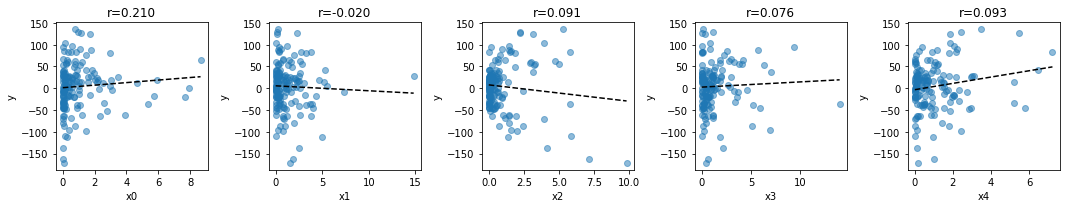

In [6]:
turb.plot.scatter_grid(df2, "x.", 'y')

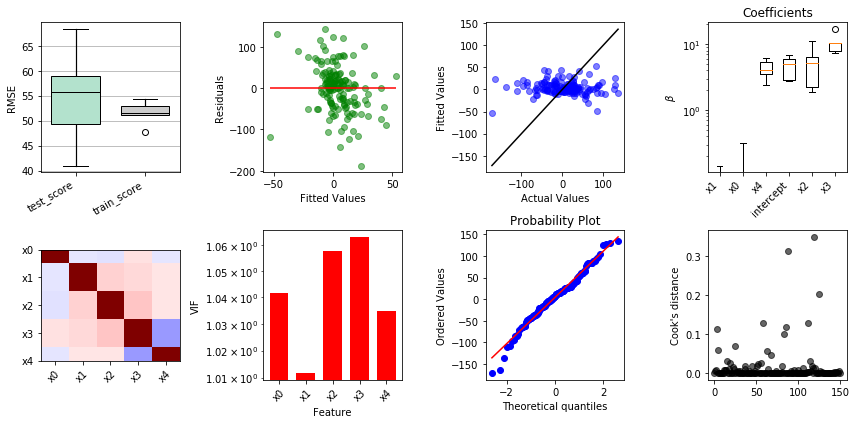

-54.68507968158343


In [7]:
cv, yp = turb.ml.fit.basic(df2, 'y', model="lm", plot=True)
print(cv['test_score'].mean())

### Fitting a model with a very small subsection of *informative* parameters

In this case, we still expect a linear model to work well because it will simply select the parameters that have the most impact:

In [8]:
_X2, _y2 = make_regression(n_samples=150, n_features=20, n_informative=4, bias=2., noise=.5)
df3 = pd.DataFrame(np.hstack((_X2, np.atleast_2d(_y2).T)), columns=turb.str.patproduct("x%d", range(20)) + ["y"])

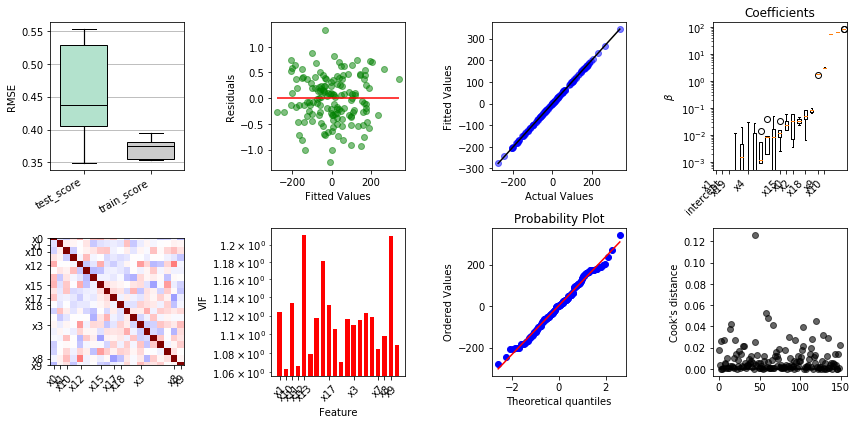

-0.45441433389165675


In [9]:
cv, yp = turb.ml.fit.basic(df3, 'y', model="lm", plot=True)
print(cv['test_score'].mean())

### Fitting a model that has an unusual matrix rank

In this instance, we will have a model that doesn't contain **full rank** input data for $X$, meaning that some of the assumptions that OLS model makes are violated:

In [10]:
_nf = 30
_X3, _y3 = make_regression(n_samples=1000, n_features=_nf, n_informative=_nf, effective_rank=_nf-5, noise=.5)
df4 = pd.DataFrame(np.hstack((_X3, np.atleast_2d(_y3).T)), columns=turb.str.patproduct("x%d", range(_nf)) + ["y"])

With only the first 10 features, with an effective rank of 25. We make a subselection like so:

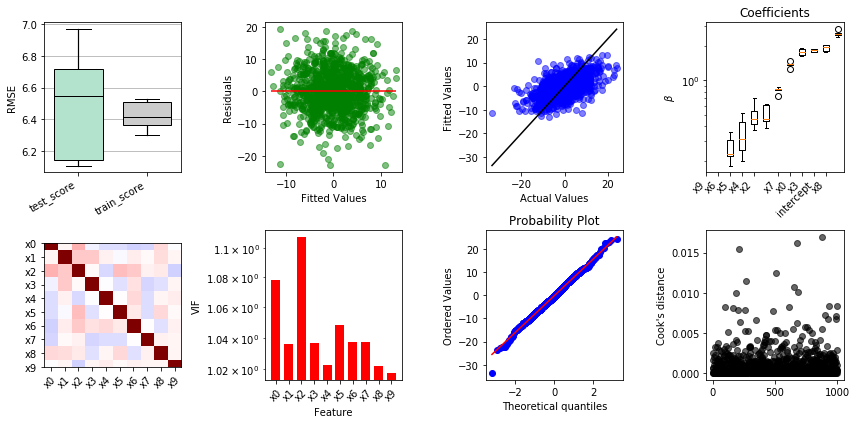

-6.497111679809846


In [11]:
cv, yp = turb.ml.fit.basic(df4, 'y', x='x[0-9]$', model="Ridge", plot=True)
print(cv['test_score'].mean())

With all of the features available:

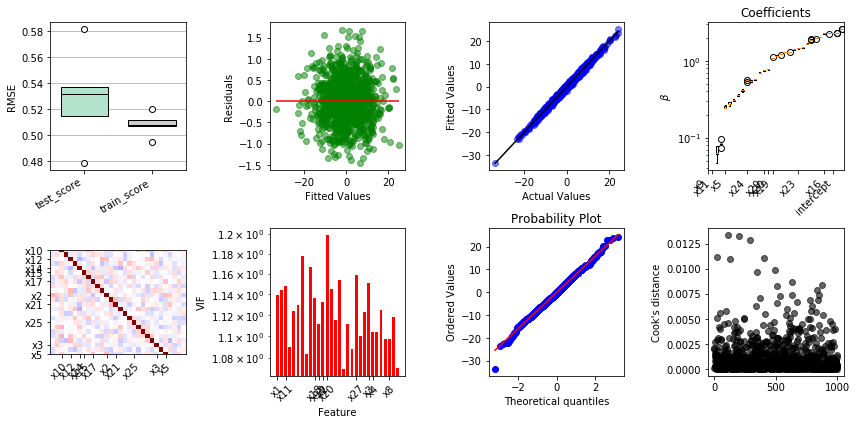

-0.528631689076945


In [12]:
cv, yp = turb.ml.fit.basic(df4, 'y', model="lm", plot=True)
print(cv['test_score'].mean())

## Non-random cases: using example datasets

We will begin with using the **California Housing Dataset** provided by sklearn:

In [13]:
from sklearn.datasets import fetch_california_housing

In [14]:
cal = fetch_california_housing()

In [15]:
df_cal = pd.DataFrame(cal['data'], columns=cal['feature_names']).assign(MedianHouseValue=cal['target'])

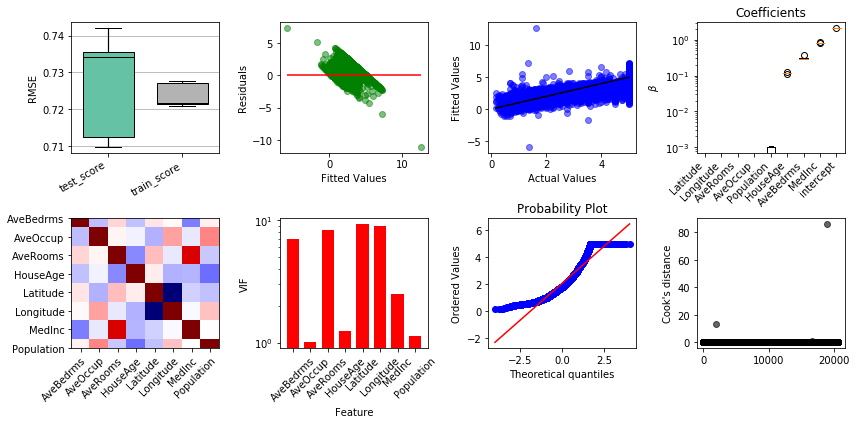

In [16]:
cv, yp = turb.ml.fit.basic(df_cal, y="MedianHouseValue", model="Ridge", plot=True)

The only issue with the above case is we don't necessarily know the best parameter to choose in order to regularize the dataset, so we need to fit a hyperparameter grid over the options.

## Fitting a parameter grid over the points

For example, we may wish to hyperparameterize $\alpha$ with a regularized linear regression model, such as Ridge or Lasso.

In the below example, by only specifying the models we wish to use, the **primary parameter** is the only one which is
iterated over using preset *default value ranges*.

For Lasso and Ridge, the primary parameter is always $\alpha$.

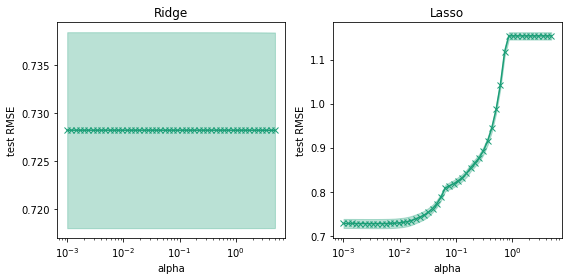

In [17]:
cv_r = turb.ml.fit.grid(df_cal, "MedianHouseValue", models=["Ridge","Lasso"], plot=True)

Below we instead specify the parameter we wish to iterate on, note here that we could specify more than one parameter.

Where there are two parameters, the secondary parameter is *split upon* into the legend, using colour.

For models which have no main parameters (i.e Ordinary Least Squares), a boxplot is displayed of the scoring value across $k$ and replicates.

In [18]:
cv_r = turb.ml.fit.grid(df_cal, "MedianHouseValue", 
                        models={
                            'lm': [],
                            'Ridge': ['alpha'], 
                            'DecisionTreeRegressor': ['max_depth', 'min_samples_split'],
                            'ElasticNet': ['alpha', 'l1_ratio']})

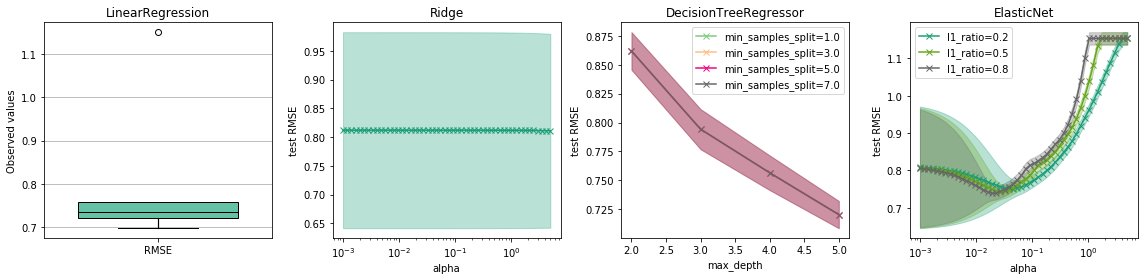

In [19]:
turb.ml.plot.parameter_tune(cv_r, arrange='column')

## Fitting using hyperparameter optimization

Instead of using a grid-based approach to exhaustively search over a domain, we could try using an optimization approach where the program **walks** towards a (ideally) global minima:

In [20]:
from sklearn.base import clone

In [21]:
from scipy import optimize as so
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [22]:
def _neg_min_function(theta, X, y, model, pnames, cv):
    # clone the model
    new_model = clone(model)
    # get the mean scores and use this as the minimization objective
    return -np.mean(
        cross_val_score(new_model.set_params(**dict(zip(pnames, theta))),
                        X, y, scoring="neg_root_mean_squared_error", cv=cv)
    )

In [23]:
param1 = ['Ridge', 'Lasso']
param2 = {'Ridge': ['alpha'], "ElasticNet": ['alpha', 'l1_ratio']}

In [24]:
turb.ml._package.find_sklearn_model("Ridge")[0]

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [25]:
X = df_cal
y = df_cal['MedianHouseValue']

param_set = turb.ml._pgrid.make_optimize_grid(param2)
for m, params in zip(param2.keys(), param_set):
    model = turb.ml._package.find_sklearn_model(m)[0].set_params(max_iter=1000)
    inits, bounds = turb.ml._pgrid.optimize_grid_for_model(params, k=3)
    print(params, inits, bounds)
    minz = [so.minimize(_neg_min_function, x0=i, args=(X, y, model, params, 5), bounds=bounds) for i in inits]

['alpha'] [[1.0], (2.571456024363475,), (4.354901369814768,), (1.2985687108771988,)] [(1e-06, 50)]
['alpha', 'l1_ratio'] [[1.0, 0.5], (4.787880107623172, 0.5436238758824821), (4.100800808106057, 0.6737243099416805), (0.9738459601082717, 0.3667462434917391)] [(1e-06, 50), (0.01, 0.99)]


## Plotting which model did best...

We want to clearly see which model does the best from a large, complicated and infuriating `GridSearchCV` call:

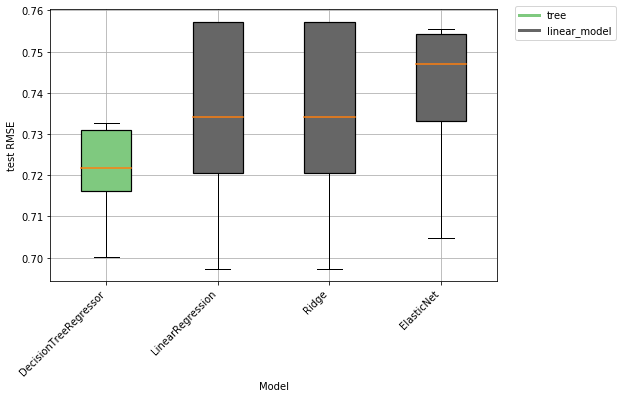

In [26]:
_ = turb.ml.plot.best_model(cv_r)

## Retrieving the best model..

Here we want to simply extract a copy of the `scikit-learn` model which performed best using a given GridSearch:

In [27]:
turb.ml.get_best_model(cv_r, minimize=False)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

## Model validation via learning curves, permutations...

In addition to the basic and grid fitting options, we can also oscillate our model such that it can estimate the *uncertainty* of how good a particular model fit is:

1. The learning curve between $N$ training sizes and test score
2. The Scalability, measuring how long each fit takes with respect to $N$ train size
3. The Performance, measuring fit times against the test score.

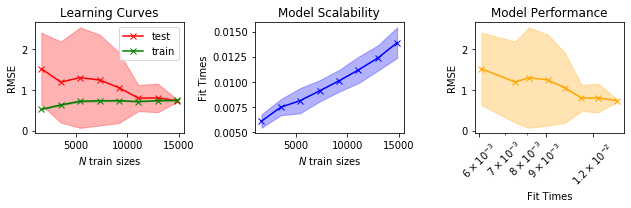

In [28]:
le_r = turb.ml.fit.learning(df_cal, y="MedianHouseValue", 
                        model='Ridge', plot=True)

The `fit.learning` has a parameter named `permute_n` which by default is set to zero. If this value is $> 0$, then a fourth plot also appears with the permutations of y as a histogram to see the variance by removing y points and performing replicates.

Also we can specify the number of samples in $N$ train sizes we want the model to take using the `train_n` parameter.

NameError: name 'x' is not defined

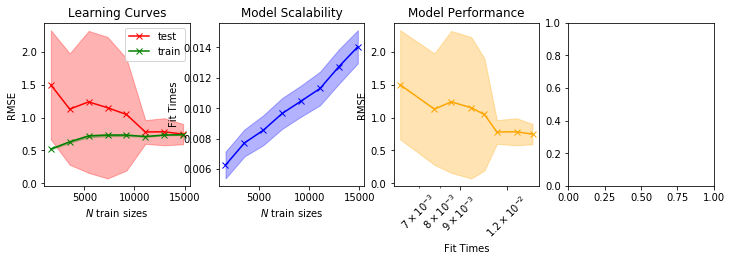

In [29]:
le_r = turb.ml.fit.learning(df_cal, y="MedianHouseValue", 
                        model='Ridge', permute_n=20, plot=True)